In [1]:
###### Package installations to work on WIRE

! pip install mamba
! pip install pysankey
! mamba install gensim openai -y
! mamba install -c anaconda nltk -y
! mamba install -c conda-forge spacy -y
! mamba install -c conda-forge pyldavis -y
! mamba install -c conda-forge pypdf2 -y
! pip install transformers sentence-transformers
! pip install scikit-network
! pip install git+https://github.com/rwalk/gsdmm.git

! python -m spacy download en_core_web_sm


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['gensim', 'openai']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━━━━━━━━━╸━━━━━━━━━━━━━   0.0 B /  ??.?

In [2]:
# imports

import csv
import json
import os
import re
from pprint import pprint
import time
import re
import unicodedata
import openai
import os
import sys
from contextlib import contextmanager
from copy import deepcopy
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
import pickle
import sknetwork as skn
from random import *

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import PyPDF2

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt", "wordnet"])
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
ps = nltk.porter.PorterStemmer()

from gsdmm import MovieGroupProcess

from sentence_transformers import SentenceTransformer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

from itertools import combinations

from scipy.spatial.distance import squareform

# set seed for reproducibility
# np.random.seed(493)

[nltk_data] Downloading package names to /home/jovyan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Packag

## Calculating Keyword Frequency and Sentiment

In [3]:
trdf = pd.read_csv("processed_transcripts_January2020.csv")
trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
trdf = trdf.explode('Topic').reset_index(drop=True)
print(trdf['Topic'].isnull().sum())
print(trdf['Sentiment'].isnull().sum())
trdf.head()


0
0


,Unnamed: 0,Transcript,Topic,Sentiment,Program
0,0,21,'impeachment',0.060427,Fox News Network INGRAHAM ANGLE
1,0,21,'word',0.060427,Fox News Network INGRAHAM ANGLE
2,0,21,'election',0.060427,Fox News Network INGRAHAM ANGLE
3,0,21,'evidence',0.060427,Fox News Network INGRAHAM ANGLE
4,0,21,'use',0.060427,Fox News Network INGRAHAM ANGLE


In [4]:
freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
print(freq_df.shape)
freq_df.head()


(51, 3637)


Topic,'abdi','ability','able','abortion','absolute','abuse','accelerate','accent','accept','acceptable',...,'young','yovanovitch','zach','zain','zeldin','zelensky','zero_experience','zion','zone','zoo'
Program,,,,,,,,,,,,,,,,,,,,,
CNN ANDERSON COOPER 360 DEGREES,0,0,3,0,0,8,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
CNN AT THIS HOUR,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CNN CNN 10,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
CNN CNN LIVE EVENT/SPECIAL,0,0,11,1,1,17,0,0,1,0,...,6,1,0,1,1,0,0,0,0,0
CNN CNN NEWSROOM,1,0,7,0,0,11,0,0,2,0,...,5,1,0,0,0,1,0,0,0,2


In [5]:
sent_df = trdf.pivot_table(index='Program', columns='Topic', values='Sentiment', aggfunc=np.mean, fill_value=0)
print(sent_df.shape)
sent_df.head()

(51, 3637)


Topic,'abdi','ability','able','abortion','absolute','abuse','accelerate','accent','accept','acceptable',...,'young','yovanovitch','zach','zain','zeldin','zelensky','zero_experience','zion','zone','zoo'
Program,,,,,,,,,,,,,,,,,,,,,
CNN ANDERSON COOPER 360 DEGREES,0.000000,0.000000,0.222330,0.000000,0.000000,-0.116098,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.000000,0.0000,0.064439,0.0,0.0,0.0,0.000000
CNN AT THIS HOUR,0.000000,-0.318318,-0.007457,0.000000,0.000000,-0.169667,0.0,0.0,0.000000,0.0,...,0.000000,0.00000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.000000
CNN CNN 10,0.000000,0.000000,0.364133,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.280900,0.00000,0.0,0.000000,0.0000,0.000000,0.0,0.0,0.0,0.000000
CNN CNN LIVE EVENT/SPECIAL,0.000000,0.000000,0.231196,0.331575,0.021425,-0.075917,0.0,0.0,-0.180040,0.0,...,0.411326,0.15920,0.0,0.463046,0.4842,0.000000,0.0,0.0,0.0,0.000000
CNN CNN NEWSROOM,0.339329,0.000000,0.003564,0.000000,0.000000,-0.099537,0.0,0.0,0.112087,0.0,...,0.061513,0.25945,0.0,0.000000,0.0000,0.522442,0.0,0.0,0.0,-0.410831


In [6]:
P = np.multiply(freq_df.to_numpy(), sent_df.to_numpy())
print(P.shape)
program_sim_network = np.matmul(P, P.T)
program_sim_network.shape

(51, 3637)


(51, 51)

In [7]:
#counting the number of nonzero results
np.count_nonzero(program_sim_network)

2601

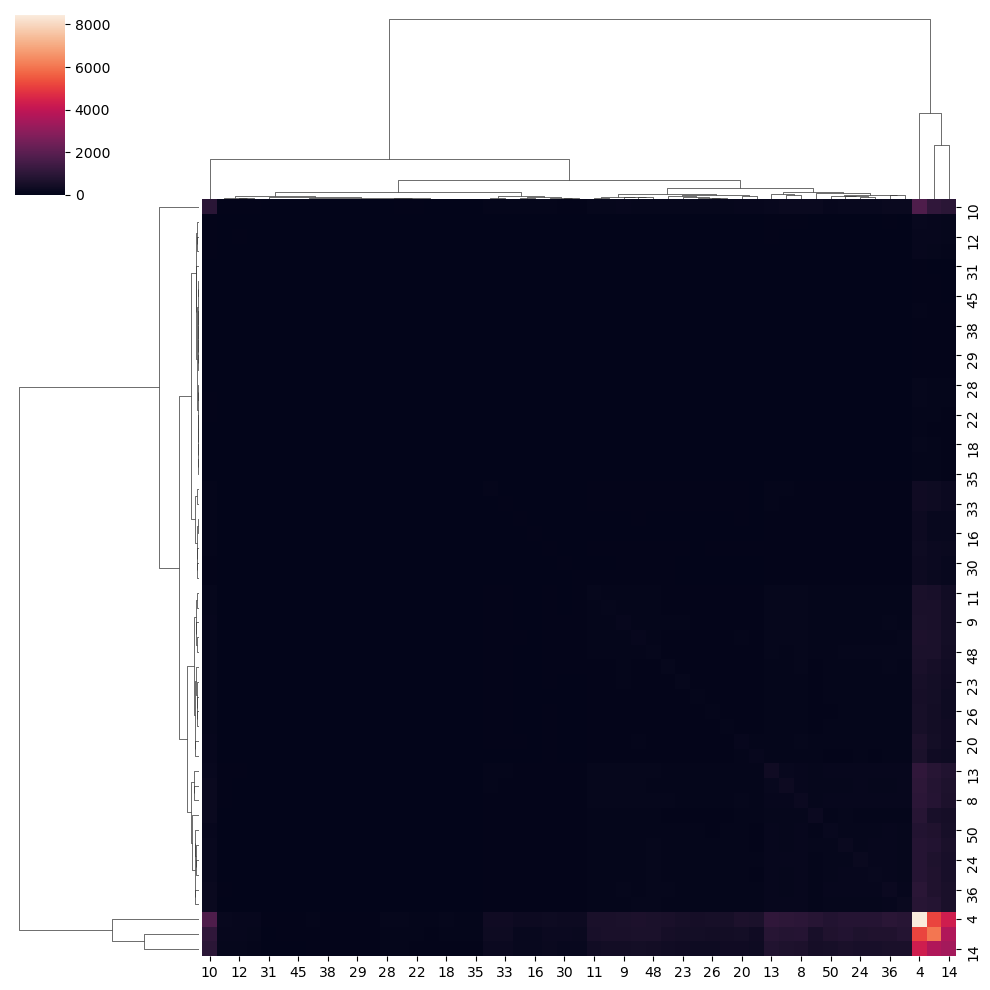

In [8]:
sns.clustermap(program_sim_network)

In [9]:
#weighing program-to-program similarity by number of topics
progs = trdf['Program'].unique()
print(len(progs))
prog_tops = []
for p in progs:
    tops = trdf[trdf['Program'] == p]
    prog_tops.append(1 / len(tops))
    
ptm = [i * j for (i, j) in combinations(prog_tops, 2)]
m = np.mean(ptm)
std = np.std(sent)
print(std)
print(m)
#diff = [(2 - abs(i - j) - m) / std for (i, j) in combinations(tr_tp_st[2], 2)]
ptm_matrix = squareform(ptm)
print(len(ptm_matrix))

51


NameError: name 'sent' is not defined

In [ ]:
P_network

In [ ]:
program_sim_network = np.multiply(program_sim_network, ptm_matrix)

In [ ]:
sns.clustermap(program_sim_network)

In [ ]:
program_sim_network.shape

In [ ]:
program_sim_network.max()

In [ ]:
network_embedding = SpectralEmbedding(affinity='precomputed')
pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())

In [ ]:
program_df = pd.DataFrame()
program_df['program'] = P_network['names_row']
program_df['network'] = program_df['program'].apply(lambda x: x.split()[0])
program_df['x_pos'] = pos_program_embeddings[:,0]
program_df['y_pos'] = pos_program_embeddings[:,1]

In [ ]:
sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')

In [11]:
from sklearn.cluster import SpectralClustering
spec_cl = SpectralClustering(
    n_clusters=3,  
    n_neighbors=20, 
    affinity='precomputed')
cluster = spec_cl.fit_predict(program_sim_network)
print(cluster)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 1 0 2 2 2 2
 2 2 2 2 2 2 2 0 2 2 2 2 2 2]


In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3) 
kmeans.fit(program_sim_network)
cluster = kmeans.predict(program_sim_network)
print(cluster)

[2 2 0 1 1 0 2 0 2 2 2 2 0 2 1 0 0 0 0 0 2 2 0 2 2 0 2 0 0 0 0 0 0 0 0 0 2
 2 0 2 2 2 0 2 0 0 2 0 2 2 2]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
from sklearn.cluster import AgglomerativeClustering
#sim_net = squareform(program_sim_network)
clustering = AgglomerativeClustering(n_clusters = 3).fit(program_sim_network) #program_sim_network)
clustering.labels_

array([1, 1, 2, 0, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1,
       2, 2, 1, 2, 1, 1, 1])

In [14]:
from sknetwork.clustering import Louvain
louvain = Louvain()
louvain = louvain.fit(P)
print(louvain.labels_)

ValueError: Node weights must be non-negative with positive sum.

In [15]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
corpus = []
for p in progs:
    trdfp = trdf[trdf['Program'] == p]
    trdfp['Topic'] = trdfp['Topic'].apply(lambda x: ' '.join(list(x)).replace("'",""))
    #print(trdfp['Topic'][0:5])
    txt = ' '.join(trdfp['Topic'])
    corpus.append(txt)
full_txt = ' '.join(corpus)
vocabulary = set(full_txt.split())
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),
                 ('tfid', TfidfTransformer())]).fit(corpus)
print(pipe['count'].transform(corpus).toarray())
print(pipe['tfid'].idf_)
pipe.transform(corpus).shape

/tmp/ipykernel_8363/2094913154.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trdfp['Topic'] = trdfp['Topic'].apply(lambda x: ' '.join(list(x)).replace("'",""))


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[4.95124372 4.95124372 4.95124372 4.95124372 4.95124372 4.95124372
 4.95124372 4.95124372 4.95124372 4.95124372 4.95124372 4.95124372
 4.95124372 4.95124372 4.95124372 4.95124372 4.95124372 4.95124372
 4.95124372 4.95124372 4.95124372 4.95124372 4.95124372 4.95124372
 4.95124372 4.95124372 4.95124372]


(51, 27)

In [ ]:
freq_df_new = TfidfTransformer().fit_transform(freq_df.to_numpy()).toarray()
print(freq_df_new[0:10][0:10])
print(freq_df_new.shape)

In [ ]:
trdf['Sentiment'].describe()

In [163]:
def funky_multipy(freq,sent):
  A = freq
  B = freq.T
  C = sent
  D = sent.T
  if  A.shape[1] == B.shape[0]:
    E = np.zeros((A.shape[0],B.shape[1]),dtype = int)
    for row in range(A.shape[0]): 
        print(row)
        for col in range(B.shape[1]):
            for elt in range(B.shape[0]):
              E[row, col] += A[row, elt] * B[elt, col] * (1 - abs(C[row, elt] - D[elt, col]) / 2)
    return E
  else:
    return "Sorry, cannot multiply A and B."


def get_clusters(trdf):
    #keyword frequency
    trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
    trdf = trdf.explode('Topic').reset_index(drop=True)
    freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
    freq_df_new = TfidfTransformer().fit_transform(freq_df.to_numpy()).toarray()
    
    #keyword sentiment
    sent_df = trdf.pivot_table(index='Program', columns='Topic', values='Sentiment', aggfunc=np.mean, fill_value=0)
    sent = sent_df.to_numpy()
    freq = freq_df.to_numpy()
    for i in range(sent.shape[0]):
        for j in range(sent.shape[1]):
            if freq[i][j] < 2:
                sent[i][j] = 0
    

    #get program simmilarities by topic
    program_topic_network = np.matmul(freq_df_new, freq_df_new.T)
    
    
    #get program simmilarity by sentiment
    progs = sent_df.index
    program_sent_network = np.array([])
    c = 0
    for p in range(len(progs)):
        sp = sent[p]
        psim = []
        for p1 in range(len(progs)):
            p_p1 = []
            sp1 = sent[p1]
            for w in range(len(sp)):
                  if sp[w] != 0 and sp1[w] != 0:
                        p_p1.append(1 - abs(sp[w] - sp1[w]) / 2)
            if len(p_p1) > 0:
                psim.append(sum(p_p1) / len(p_p1))
            else:
                psim.append(0)
                c += 1
            #print(len(p_p1))
        program_sent_network = np.append(program_sent_network, psim, axis=0)
    program_sent_network = (np.reshape(program_sent_network, [len(progs), len(progs)]) - program_sent_network.min()) / program_sent_network.max()
    print(c)
    
    #program_sim_network = np.multiply(program_topic_network, program_sent_network)
    program_sim_network = program_topic_network * program_sent_network

    
    
    network_embedding = SpectralEmbedding(affinity='precomputed')
    pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())
    program_df = pd.DataFrame()
    program_df['program'] = progs
    program_df['network'] = pd.Series(progs).apply(lambda x: x.split()[0])
    program_df['x_pos'] = pos_program_embeddings[:,0]
    program_df['y_pos'] = pos_program_embeddings[:,1]
    sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')
    plt.show()
    #network_embedding = SpectralEmbedding(affinity='precomputed')
    #pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())
    
    #clustering
    clustering = AgglomerativeClustering(n_clusters = 3).fit(program_sim_network)
    clust_df = pd.DataFrame(list(zip(progs, list(clustering.labels_))),
               columns =['Program', 'Cluster'])
    return clust_df

204


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


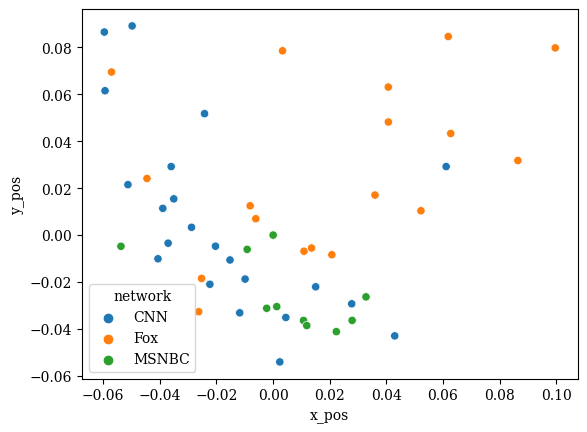

109


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


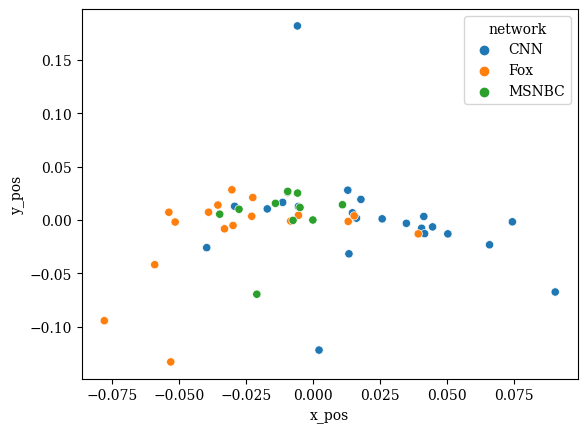

202


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


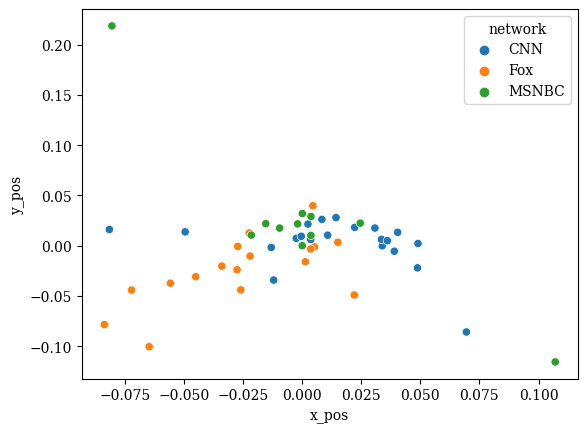

269


/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


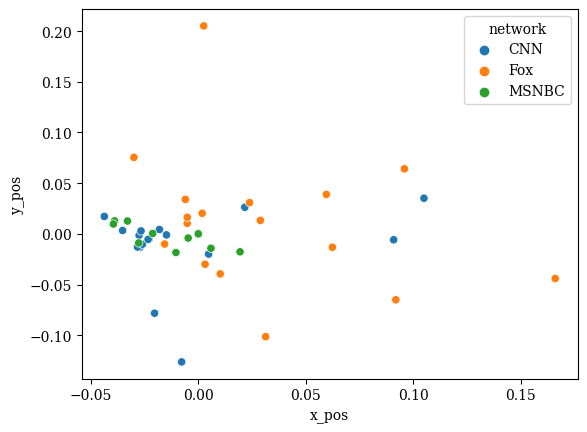

In [164]:
data = ['processed_transcripts_January2020.csv','processed_transcripts_February2020.csv',
        'processed_transcripts_March2020.csv','processed_transcripts_April2020.csv']
for i in range(len(data)):
    trdf = pd.read_csv(data[i])
    clust_df = get_clusters(trdf)
    clust_df = clust_df.rename(columns={'Cluster': 'Cluster_' + str(i)})
    if i == 0:
        clusters_df = clust_df
    else:
        clusters_df = clusters_df.merge(clust_df, on = 'Program', how = 'left')
    #print(clusters_df)

In [138]:
 #keyword frequency
trdf = pd.read_csv(data[0])
if 1 == 1:
    trdf.Topic = trdf.Topic.apply(lambda x: x.strip('][').split(', '))
    trdf = trdf.explode('Topic').reset_index(drop=True)
    freq_df = trdf.pivot_table(index='Program', columns='Topic', values = 'Sentiment', aggfunc=len, fill_value=0)
    freq_df_new = TfidfTransformer().fit_transform(freq_df.to_numpy()).toarray()
    
    #keyword sentiment
    sent_df = trdf.pivot_table(index='Program', columns='Topic', values='Sentiment', aggfunc=np.mean, fill_value=0)
    sent = sent_df.to_numpy()
    
    

    #get program simmilarities by topic
    program_topic_network = np.matmul(freq_df_new, freq_df_new.T)
    
    #get program simmilarity by sentiment
    progs = sent_df.index
    program_sent_network = np.array([])
    for p in range(len(progs)):
        sp = sent[p]
        psim = []
        for p1 in range(len(progs)):
            p_p1 = []
            sp1 = sent[p1]
            for w in range(len(sp)):
                  if sp[w] != 0 and sp1[w] != 0:
                        p_p1.append(1 - abs(sp[w] - sp1[w]) / 2)
            if len(p_p1) > 0:
                psim.append(sum(p_p1) / len(p_p1))
            else:
                psim.append(0)
            #print(len(p_p1))
        program_sent_network = np.append(program_sent_network, psim, axis=0)
    program_sent_network = (np.reshape(program_sent_network, [len(progs), len(progs)]) - program_sent_network.min()) / program_sent_network.max()
    
    
    #program_sim_network = np.multiply(program_topic_network, program_sent_network)
    program_sim_network = program_topic_network * program_sent_network


In [139]:
print(freq_df.index)
print(freq_df.index)

Index(['CNN ANDERSON COOPER 360 DEGREES', 'CNN AT THIS HOUR', 'CNN CNN 10',
       'CNN CNN LIVE EVENT/SPECIAL', 'CNN CNN NEWSROOM',
       'CNN CNN RELIABLE SOURCES', 'CNN CNN RIGHT NOW',
       'CNN CNN Special Reports', 'CNN CNN Tonight', 'CNN CUOMO PRIME TIME',
       'CNN EARLY START', 'CNN ERIN BURNETT OUTFRONT',
       'CNN FAREED ZAKARIA GPS', 'CNN Inside Politics', 'CNN New Day',
       'CNN New Day Saturday', 'CNN New Day Sunday',
       'CNN S.E. CUPP UNFILTERED', 'CNN STATE OF THE UNION', 'CNN Smerconish',
       'CNN THE SITUATION ROOM', 'CNN The Lead with Jake Tapper',
       'Fox News Network FOX AND FRIENDS', 'Fox News Network FOX HANNITY',
       'Fox News Network FOX NEWS @ NIGHT', 'Fox News Network FOX NEWS SUNDAY',
       'Fox News Network FOX SPECIAL REPORT WITH BRET BAIER',
       'Fox News Network INGRAHAM ANGLE',
       'Fox News Network JUSTICE WITH JUDGE PIRRO',
       'Fox News Network LIFE LIBERTY LEVIN', 'Fox News Network LIVE EVENT',
       'Fox News Netwo

In [121]:
print(program_sent_network.mean())
print(program_sent_network.min())
print(program_sent_network.std())
print(program_topic_network.mean())
print(program_topic_network.std())
print(program_topic_network.max())
print(program_topic_network.min())
print(program_sim_network.mean())
print(program_sim_network.std())
print(program_sim_network.max())

0.09404814833156658
0.0
0.027097145180996006
0.3652894537587148
0.18558995874075473
1.0000000000000036
0.04426751398740633
0.037243857704049886
0.02882067784551341
0.19001188813434444


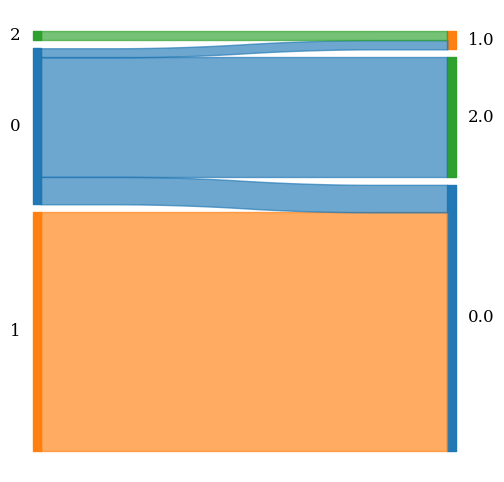

In [160]:
#print(clusters_df)
sankey_df = clusters_df.dropna()
#print(sankey_df)

from pySankey.sankey import sankey

pd.options.display.max_rows = 8

colorDict = {
    0:'#1f77b4',
    1:'#ff7f0e',
    2:'#2ca02c',
    3: '#d62728',
    4: '#9467bd',
    5: '#8c564b',
    6: '#f3f71b',
}
sankey(
    sankey_df['Cluster_0'],sankey_df['Cluster_2'], aspect=20, colorDict=colorDict,
    fontsize=12
)

In [79]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["A1", "A2", "A3","B1", "B2", "B3","C1", "C2","C3"],
      color = "blue"
    ),
    link = dict(
      source = [0, 1, 0, 2, 3, 3], # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = [2, 3, 3, 4, 4, 5],
      value = [8, 4, 2, 8, 4, 2]
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

AttributeError: module 'plotly.graph_objects' has no attribute 'Figure'

In [ ]:
! pip install ipysankeywidget
! jupyter nbextension enable --py --sys-prefix ipysankeywidget
! jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
import pandas as pd
from floweaver import *
sankey_df['Count'] = 1
flows = (
    sankey_df.groupby(["Cluster_0", "Cluster_1", "Cluster_2","Cluster_3"])
    .agg({"Count": "count"})
    .dropna()
    .reset_index()
    .rename(
        columns={
            "Cluster_0": "source",
            "Cluster_1": "type",
            #"Cluster_2": "March",
            "Cluster_3": "target",
            "Count": "value",
        }
    )
)
print(flows)

# 1. Define a new waypoint node
nodes = {
    "January": ProcessGroup(sankey_df['Cluster_0'].unique().tolist()),
    "April":ProcessGroup(sankey_df['Cluster_3'].unique().tolist()),
}
nodes["February"] = Waypoint(sankey_df['Cluster_1'])
#nodes["March"] = Waypoint(sankey_df['Cluster_2'])

# 2. Update the ordering to show where the waypoint goes: in the middle
ordering = [
    ["January"],
    ["February"],
    #["March"],
    ["April"],
]

embark_port = Partition.Simple("process", flows["source"].unique().tolist())
disembark_port = Partition.Simple("process", flows["target"].unique().tolist())
cruise_region = Partition.Simple("type", flows.type.unique())

nodes["January"].partition = embark_port
nodes["April"].partition = disembark_port
nodes["February"].partition = cruise_region

# 3. Update the bundle definition to send the flows via the waypoint
bundles = [
    Bundle("January", "April", waypoints=["February"]),
]

# Update the SDD with the new nodes, ordering & bundles.
sdd = SankeyDefinition(nodes, bundles, ordering)

weave(sdd, flows, link_color=QuantitativeScale("value", palette='Blues_9')).to_widget().auto_save_png(
    "waypoint.png"
)

## Plotting programs (M2) with a bunch of manifold learning methods
### Plot color is program channel
Plot code pulled from here: https://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html#sphx-glr-auto-examples-manifold-plot-manifold-sphere-py

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

# Variables for manifold learning.
n_neighbors = 6
n_samples = 51

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (51, n_neighbors), fontsize=14
)

#colors just a list of program channels for use in graphs
colors = []
for p in progs:
    if 'CNN' in p:
        colors.append(0)
    elif 'MSNBC' in p:
        colors.append(-1)
    elif 'Fox' in p:
        colors.append(1)
    else:
        print('ah')

#colors = colors[:1340]

sphere_data = program_sim_network

# Perform Locally Linear Embedding Manifold learning
methods = ["standard", "ltsa", "hessian", "modified"]
labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]

for i, method in enumerate(methods):
    t0 = time()
    trans_data = (
        manifold.LocallyLinearEmbedding(
            n_neighbors=n_neighbors, n_components=2, method=method
        )
        .fit_transform(sphere_data)
        .T
    )
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")

# Perform Isomap Manifold learning.
t0 = time()
trans_data = (
    manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
    .fit_transform(sphere_data)
    .T
)
t1 = time()
print("%s: %.2g sec" % ("ISO", t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ("Isomap", t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1, normalized_stress="auto")
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=n_neighbors)
trans_data = se.fit_transform(sphere_data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

plt.show()